In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix,
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from db import get_db_connection

In [13]:
conn = get_db_connection()
query = 'SELECT * FROM lb_comments;'
df = pd.read_sql(query,conn)
conn.close()

C:\Users\marci\AppData\Local\Temp\ipykernel_26356\2065160649.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,conn)


In [14]:
df['label'] = df['classification'].map({'BOM' : 2, 'NEUTRO' : 1, 'RUIM' : 0})

In [15]:
df['comment_text'] = df['comment_text'].str.lower()

In [16]:
df = df[['comment_text', 'label']]

In [17]:
df.drop_duplicates(inplace=True)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['comment_text'], df['label'], test_size=0.2, random_state=42)

In [19]:
classes = ['BOM', 'NEUTRO', 'RUIM']
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

In [22]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('naive_bayes', MultinomialNB())
])

In [23]:
params = {
    'naive_bayes__alpha': [0.1, 0.5, 1.0]
}

In [24]:
grid_search = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='accuracy')

In [25]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('naive_bayes', MultinomialNB())]),
             n_jobs=-1, param_grid={'naive_bayes__alpha': [0.1, 0.5, 1.0]},
             scoring='accuracy')

In [26]:
y_pred = grid_search.predict(X_test)
print('---- Naive Bayes ----')
print(classification_report(y_test, y_pred, target_names=classes))
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score (Cross-validation accuracy): {grid_search.best_score_:.4f}\n')

---- Naive Bayes ----
              precision    recall  f1-score   support

         BOM       0.52      0.90      0.66        40
      NEUTRO       0.65      0.58      0.62        62
        RUIM       0.85      0.46      0.59        48

    accuracy                           0.63       150
   macro avg       0.67      0.65      0.62       150
weighted avg       0.68      0.63      0.62       150

Best Parameters: {'naive_bayes__alpha': 0.5}
Best Score (Cross-validation accuracy): 0.6712



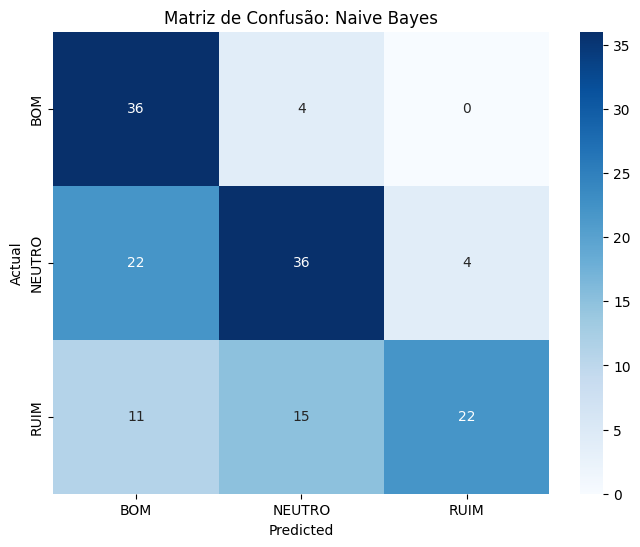

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Matriz de Confusão: Naive Bayes')
plt.show()

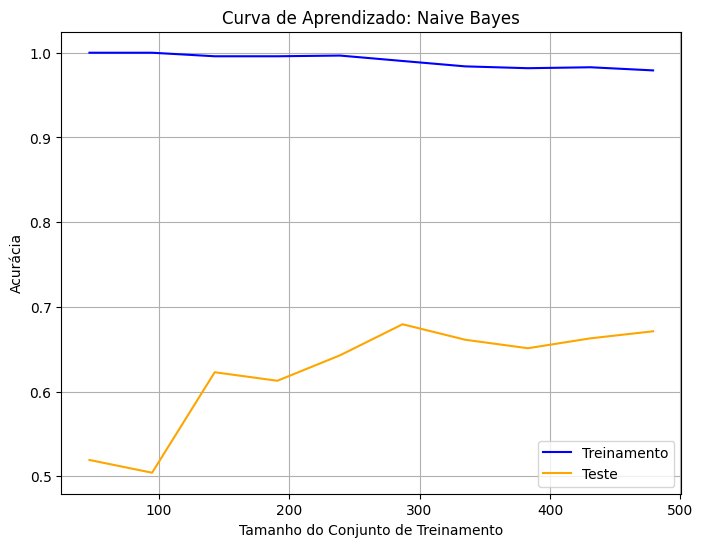

In [28]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_train, y_train, 
                                                        cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Treinamento', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Teste', color='orange')
plt.title('Curva de Aprendizado: Naive Bayes')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.legend(loc='best')
plt.grid()
plt.show()